In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from config import getConfig

In [2]:
pd.set_option('mode.chained_assignment', None)

In [3]:
def getAcct(cfg, symbol):
    df = pd.read_csv(cfg['ETrade']['dataLoc']+'accountValues.csv')
    df = formatDate(df)
    if symbol == '*':
        acct = df.groupby('date', as_index=False)['value'].sum()
    else:
        acct = df[df['account']==symbol][['date', 'value']]
    acct.set_index('date', inplace=True)
    return acct.sort_index()

In [4]:
def formatDate(df):
    df['date'] = df['date'].apply(lambda x: pd.to_datetime(x).date())
    return df

In [5]:
def getBenchmark():
    df = pd.read_csv('~/data/investing/SPY_yahoo.csv')
    df = df[['Date', 'Close']]
    df.columns = ['date', 'price']
    df = formatDate(df)
    return df.set_index('date')

In [6]:
def adjustDate(df):
    '''
    We have to align the deposit dates, which can be any day of the month,
    with the value dates, which are always the first of the month
    '''
    def func(x):
        yr, mo, dy = int(x[:4]), int(x[5:7]), int(x[-2:])
        if dy <16:
            dy='01'
        else:
            dy='01'
            if mo < 12:
                mo+=1
            else:
                mo=1
                yr+=1
        strDate = str(yr)+str(mo).zfill(2)+str(dy).zfill(2)
        return pd.to_datetime(strDate).date()
    df['date'] = df['date'].apply(lambda x: func(x))
    return df

In [7]:
def getDeposits(symbol):
    df = pd.read_csv('~/data/investing/etrade/deposits.csv')
    if symbol == '*':
        df = df.groupby('date', as_index=False)['amount'].sum()
    else:
        df = df[df['account']==symbol]
    df = adjustDate(df)
    df.rename({'amount': 'depositAmt'}, axis=1, inplace=True)
    df = df.groupby('date')['depositAmt'].sum()
    return df

In [8]:
cfg = getConfig()

In [22]:
#symbol = 'nonQual'
symbol = 'SEP'
#symbol = 'traditionalIRA'
#symbol = 'Roth'
symbol = '*'

##### Get the ETrade account value plus the benchmark price history

In [23]:
acct = getAcct(cfg, symbol)
spx = getBenchmark()
acct = acct.join(spx, how='inner')

##### Deposits

In [24]:
dep = getDeposits(symbol)
# Add deposits to Benchmark
acct = acct.join(dep, how='left')
acct.fillna(0, inplace=True)

# Calculate the number of shares of the benchmark the various deposits would buy
acct['numShares'] = acct['depositAmt']/acct['price']
acct['numShares'] = acct['numShares'].cumsum()
# Now the Benchmark value based on those shares
acct['benchmark'] = acct['price']*acct['numShares']

In [28]:
# If you want to see a recent subset
startDt = None
startDt = pd.to_datetime('2021-01-01').date()
if startDt:
    df = acct[acct.index>=startDt]
    df.loc[:, 'benchmark'] = df['benchmark'] / df['benchmark'][0]
    df.loc[:, 'value'] = df['value'] / df['value'][0]
else:
    df = acct

In [29]:
plt.rc('font', size=20) 

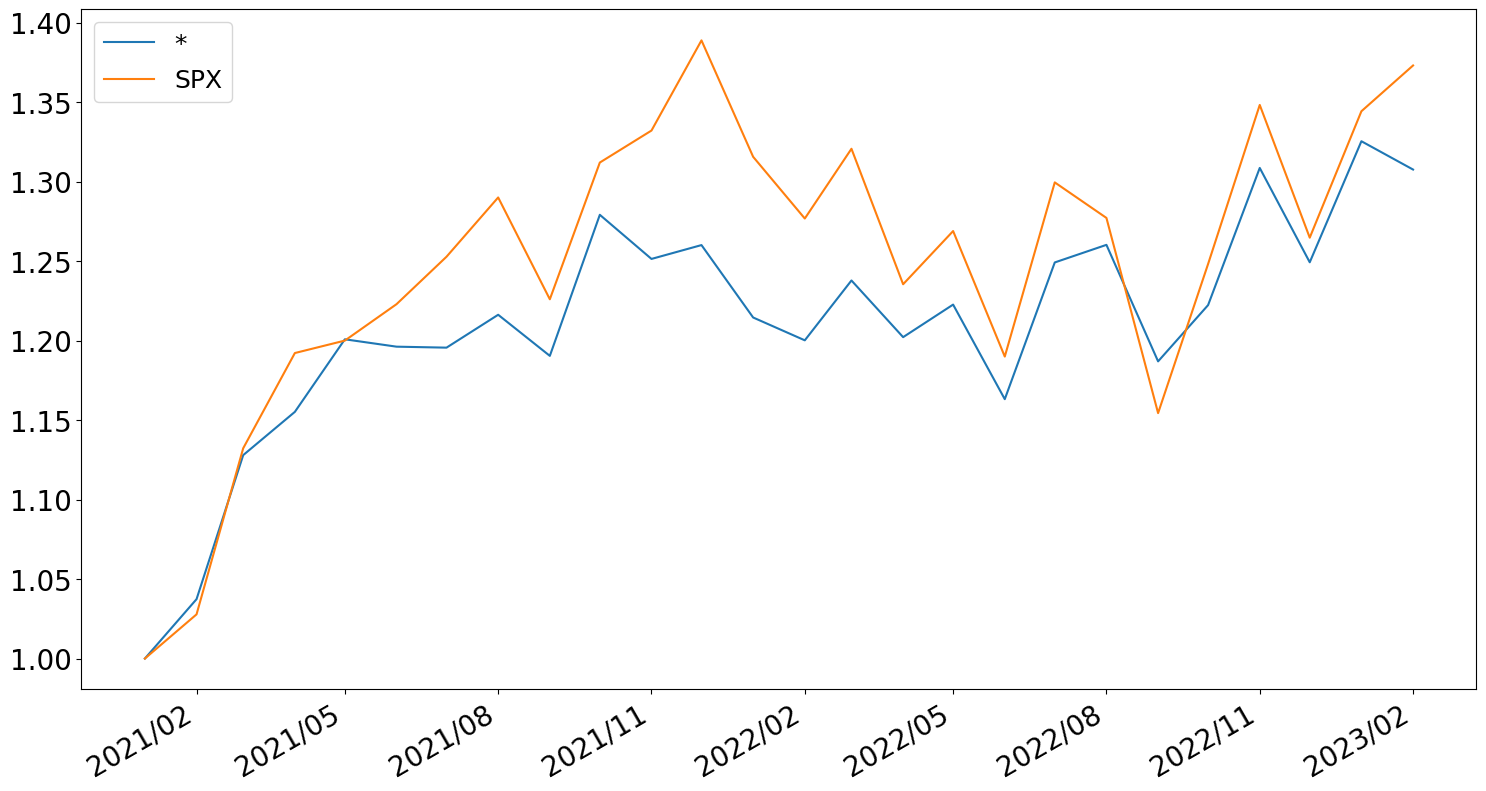

In [30]:
plt.figure(figsize=(18, 10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.plot(df['value'], label=symbol)
plt.plot(df['benchmark'], label='SPX')
plt.gcf().autofmt_xdate()
plt.legend(prop={'size': 18})
plt.show()